We begin with loading the necessary libraries. We will pretty much the same libraries as next week with three additions: **scipy** for matrix operations, **seaborn** for better looking plots and **statsmodels** for full linear regression output

In [1]:
import numpy as np             
import pandas as pd  #Python Data Analysis Library handle data in a user friendly way
import scipy as sc
import matplotlib.pyplot as plt #for plots
import seaborn as sns # for better plots
%matplotlib inline
from sklearn import linear_model # A very popular Python library for Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #needed to for assessing prediction
from sklearn import datasets ## imports datasets from scikit-learn
import statsmodels.api as sm

We will begin with generating data.

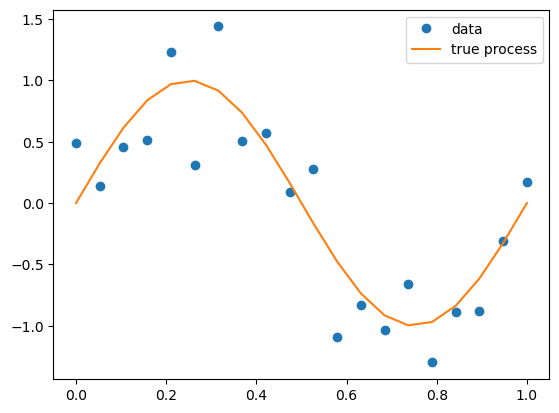

In [2]:
#Polynomial fitting exercises
np.random.seed(1)
n = 20 #number of points
x = np.linspace(0, 1, n)
f = np.sin(2*np.pi*x)
y = f+0.3*np.random.randn(n)
#plt.plot(xg,f,label='true process')
plt.plot(x,y,'o',label='data')
plt.plot(x,f,label='true process')
plt.legend()

We put x,y into the pandas dataframe called data. Also put a vector of ones as x0.

In [3]:
x0 = np.ones(n)
data = pd.DataFrame(np.column_stack([y,x0,x]),columns=['y','x0','x']) 
#Expand the data including powers of x up to 10
for i in range(2,11):  #executes the following indented commands for i varying from 3 to 9
    colname = 'x%d'%i # the %d %i puts a different number in the name of each variable
    data[colname] = data['x']**i #raise to the power of i
    # the for loop continues until the first time a command is not indented.
data.head()

,y,x0,x,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0.487304,1.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.141173,1.0,0.052632,0.002770,0.000146,0.000008,4.038611e-07,2.125585e-08,1.118729e-09,5.888046e-11,3.098972e-12,1.631038e-13
2,0.455761,1.0,0.105263,0.011080,0.001166,0.000123,1.292355e-05,1.360374e-06,1.431973e-07,1.507340e-08,1.586673e-09,1.670183e-10
3,0.515276,1.0,0.157895,0.024931,0.003936,0.000622,9.813824e-05,1.549551e-05,2.446660e-06,3.863147e-07,6.099706e-08,9.631114e-09
4,1.229023,1.0,0.210526,0.044321,0.009331,0.001964,4.135537e-04,8.706395e-05,1.832925e-05,3.858790e-06,8.123768e-07,1.710267e-07


d:\Python\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


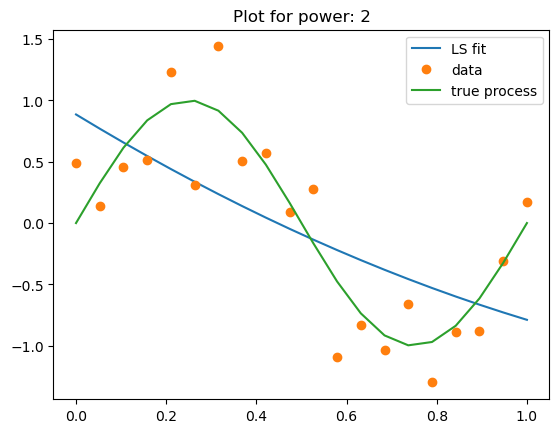

In [4]:
npower = 2
predictors = ['x']
predictors.extend(['x%d'%i for i in range(2,npower+1)])
linreg = LinearRegression(fit_intercept=True,normalize=False)
linreg.fit(data[predictors],data['y'])
y_pred = linreg.predict(data[predictors])
plt.plot(data['x'],y_pred, label='LS fit')
plt.plot(data['x'],data['y'],'o',label='data')
plt.plot(x,f,label='true process')
plt.title('Plot for power: %d'%npower)
plt.legend()

### Matrix operations

Below we find the MLE without the scikit linear regression function. For that we

1. Form the design matrix $X$ and the response vector y
2. Calculate the MLE as $$\hat{\beta} = (X^T X)^{-1}X^T y$$

Write the code that generates MLE coefficents, i.e, $\beta$:

In [5]:
# print(1/data['x'])

X = data[['x0','x','x2']]
y = data['y']
beta = np.linalg.inv(X.T@X)@(X.T)@y

beta = beta.array
print(beta)


<PandasArray>
[0.8851651079530514, -2.23262045751021, 0.558704441140444]
Length: 3, dtype: float64


Check the $\beta$ you found with the scikit function:

In [6]:
print ('Intercept: ', linreg.intercept_)

print ('Coefficients: ', linreg.coef_)


Intercept:  0.8851651079530479
Coefficients:  [-2.23262046  0.55870444]


We can go beyond the point estimate and calculate the variance of $\hat{\beta}$.

The code below provides $\hat{\sigma}^2$, the covariance matrix $$\mbox{var}[\hat{\beta}] = \hat{\sigma}^2 (X^T X)^{-1}, $$
and its diagonal.

In [7]:
n,p = X.shape
e = y - X.dot(beta)# beta is your derived MLE coefficents in the previous cells
sigma2_hat = e.T.dot(e)/(n-p)
var_beta = sigma2_hat*(sc.linalg.inv(X.T.dot(X)))
sigma2_hat, var_beta, np.diag(var_beta)

(0.38812469825123386,
 array([[ 0.14390857, -0.56026052,  0.45491239],
        [-0.56026052,  3.09180807, -2.8811118 ],
        [ 0.45491239, -2.8811118 ,  2.8811118 ]]),
 array([0.14390857, 3.09180807, 2.8811118 ]))

With the above quantities we can calculate confidence intervals for MLE's. For those we will need the 97.5\% point of the $t_{n-p}$ distribution. 

The following code does that and also puts the results in pandas dataframe.

In [8]:
#calculate 95% CI for beta and present output via a pandas data frame 
tval = sc.stats.t.ppf(0.975,n-p)
std_beta = np.sqrt(np.diag(var_beta))
lower95 = beta - tval*std_beta
upper95 = beta + tval*std_beta
results = np.column_stack([beta,std_beta,lower95,upper95])
col = ['coefficient','se','lower 95% bound','upper 95% bound']
ind = ['intercept','x','x2']
results = pd.DataFrame(results,columns = col,index=ind)
results

,coefficient,se,lower 95% bound,upper 95% bound
intercept,0.885165,0.379353,0.084801,1.685530
x,-2.232620,1.758354,-5.942423,1.477182
x2,0.558704,1.697384,-3.022462,4.139871


To check our answers we also use the relevant function (.OLS) of the library **statsmodels**  

In [9]:
Poly = ['x','x2']
X = data[Poly]
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     6.704
Date:                Wed, 16 Nov 2022   Prob (F-statistic):            0.00714
Time:                        23:57:04   Log-Likelihood:                -17.289
No. Observations:                  20   AIC:                             40.58
Df Residuals:                      17   BIC:                             43.57
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8852      0.379      2.333      0.032       0.085       1.686
x             -2.2326      1.758     -1.270      0.221      -5.942       1.477
x2             0.5587      1.697      0.329      0.746      -3.022       4.140
==============================================================================
Omnibus:                        1.146   Durbin-Watson:                   1.109
Prob(Omnibus):                  0.564   Jarque-Bera (JB):                1.040
Skew:                           0.412   Prob(JB):                        0.595
Kurtosis:                       2.245   Cond. No.                         20.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the following cells:
1. Obtain the MLEs and 95\% confidence intervals for the 3rd order polynomial without using any Python built in function. 
2. Check your answers against the statsmodels corresponding function (.OLS)

In [10]:
X = data[['x0','x','x2','x3']]
y = data['y']
beta_hat = np.linalg.inv(X.T@X)@(X.T)@y
beta_hat = np.array(beta_hat)

n,p = X.shape
e = y - X.dot(beta_hat)# beta is your derived MLE coefficents in the previous cells
sigma2_hat = e.T.dot(e)/(n-p)
var_beta = sigma2_hat*(sc.linalg.inv(X.T.dot(X)))
sigma2_hat, var_beta, np.diag(var_beta)

tval = sc.stats.t.ppf(0.975,n-p)
std_beta = np.sqrt(np.diag(var_beta))
lower95 = beta_hat - tval*std_beta
upper95 = beta_hat + tval*std_beta
results = np.column_stack([beta_hat,std_beta,lower95,upper95])
col = ['coefficient','se','lower 95% bound','upper 95% bound']
ind = ['intercept','x','x2','x3']
results = pd.DataFrame(results,columns = col,index=ind)
results


,coefficient,se,lower 95% bound,upper 95% bound
intercept,-0.010460,0.290987,-0.627324,0.606404
x,10.124663,2.586393,4.641755,15.607572
x2,-31.139397,6.102501,-44.076122,-18.202672
x3,21.132068,4.006810,12.638011,29.626125


In [11]:
Poly = ['x','x2','x3']
X = data[Poly]
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     20.79
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           9.12e-06
Time:                        23:57:05   Log-Likelihood:                -7.2153
No. Observations:                  20   AIC:                             22.43
Df Residuals:                      16   BIC:                             26.41
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0105      0.291     -0.036      0.972      -0.627       0.606
x             10.1247      2.586      3.915      0.001       4.642      15.608
x2           -31.1394      6.103     -5.103      0.000     -44.076     -18.203
x3            21.1321      4.007      5.274      0.000      12.638      29.626
==============================================================================
Omnibus:                        0.301   Durbin-Watson:                   2.750
Prob(Omnibus):                  0.860   Jarque-Bera (JB):                0.470
Skew:                           0.142   Prob(JB):                        0.790
Kurtosis:                       2.305   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We will now put all the previous talk into a function. In other words we will create our own function rather than using the stasmodels/scikit learn ones. 

The inputs of the function will be $X$, $y$ and the names of the predictors. The output will be a data frame with the results (MLE's, se's and 95\% CI's).

Write this function  below.

In [12]:
def MLE(X,y,order):
    beta_hat = np.linalg.inv(X.T@X)@(X.T)@y
    beta_hat = np.array(beta_hat)
    n,p = X.shape
    e = y - X.dot(beta_hat)# beta is your derived MLE coefficents in the previous cells
    sigma2_hat = e.T.dot(e)/(n-p)
    var_beta = sigma2_hat*(sc.linalg.inv(X.T.dot(X)))
    sigma2_hat, var_beta, np.diag(var_beta)

    tval = sc.stats.t.ppf(0.975,n-p)
    std_beta = np.sqrt(np.diag(var_beta))
    lower95 = beta_hat - tval*std_beta
    upper95 = beta_hat + tval*std_beta
    results = np.column_stack([beta_hat,std_beta,lower95,upper95])
    col = ['coefficient','se','lower 95% bound','upper 95% bound']
    index = ['intercept']
    
    for i in range(0,order):
        if i==0:
            index.insert(1,'x')
        
        else:
            index.insert(i+1, 'x%d'%(i+1))
    results = pd.DataFrame(results,columns = col,index=index)
    return results
X = data[['x0','x','x2','x3']]
y = data['y']
results = MLE(X,y,3)
results


,coefficient,se,lower 95% bound,upper 95% bound
intercept,-0.010460,0.290987,-0.627324,0.606404
x,10.124663,2.586393,4.641755,15.607572
x2,-31.139397,6.102501,-44.076122,-18.202672
x3,21.132068,4.006810,12.638011,29.626125


### Bayesian Linear Regression

We now turn to Bayesian inference. As before we will illustrate and then create a function that provides summaries of the posterior (Bayes estimates of $\beta$ and 95\% Credible Intervals).

We start by calculating the posterior parameters that correspond to the unit information prior.

Given $\sigma^2$ and a **prior** of N($\mu_0,\sigma^2\Omega_0)$, the **posterior** $\pi(\beta|X,y,\sigma^2)$ is N($\mu_n,\sigma^2\Omega_n^2$) where

$$\mu_n = (X^T X+\Omega_0^{-1})^{-1} (\Omega_0^{-1}\mu_0 +X^{T}y)$$
$$\Omega_n =(X^T X +\Omega_0^{-1})^{-1}$$

To assign the unit information prior we set $\Omega_0 = n(X^T X)^{-1}$ or else $\Omega_0^{-1}=X^T X / n$.

For $\sigma^2$ if we set the **prior** IGamma$(a_0,b_0)$ we get the **posterior** IGamma$(a_n,b_n)$ where
$$
a_n = a_0+\frac{n}{2}
$$
$$
b_n = b_0+\frac{1}{2} (y^T y + \mu_0^T\Omega_0^{-1}\mu_0 +\mu_n^T\Omega_n^{-1}\mu_n).
$$

Calculate posterior parameters in the following cell

In [13]:
omega0 = n*np.linalg.inv(X.T@X)
mm,nn = omega0.shape
omega0_inverse = (X.T@X)/n
# mu_0 = data['y'].mean()
mu_0 = np.zeros(mm).T
print(len(beta_hat))
y = data['y']
a0  = 1 # initialize a0 
b0  = 1
a_n = a0+n/2
omega_n = np.linalg.inv(X.T@X+omega0_inverse)
z = (X.T@y)
mu_n = omega_n@(omega0_inverse@mu_0+z)
omega_n_inverse = np.linalg.inv(omega_n)
b_n = b0+0.5*(y.T@y+mu_0.T@omega0_inverse@mu_0+mu_n.T@omega_n_inverse@mu_n)


a_n,b_n


4


(11.0, 11.404656027602837)

#### Monte Carlo for credible intervals

To obtain credible intervals for $\beta$ we could use the $t$ distribution. But we would use Monte Carlo instead as this will cover more general models. e.g. logistic regression.

So we will sample $N$ Monte Carlo samples from $\pi(\beta|y)$ and use them  for Monte Carlo inference (credible intervals, density plots etc)

Monte Carlo Samples can be drawn by

1. Generating samples $\sigma_i^2$ from IGamma$(\alpha_n,\beta_n)$, $i=1,\dots,N$,
2. Draw $\beta_i$ sample based on each $\sigma_i^2$ from N($\mu_n,\sigma^2\Omega_n^2$)

In [14]:
#Calculate 95% credible intervals
N = 10000 #number of Monte Carlo samples
sigma2 = 1/np.random.gamma(a_n, 1/b_n, N)
betas = np.zeros((N,mm))
# draw N samples from the marginal posterior of beta
for i in range(0,N):
    s2 =sigma2[i]
    cov = s2*omega_n
    betas[i,] = np.random.multivariate_normal(mu_n,cov,1)

#find the mean of each column which corresponds to each beta coefficient     
mu_beta = np.mean(betas, axis=0)
#find the 2.5 and 97.5 percentils which correspond to each beta coefficient 
lower95 = np.percentile(betas,2.5,axis=0)
upper95 = np.percentile(betas,97.5,axis=0)
mu_beta, lower95, upper95

(array([-8.45280810e-03,  9.63522647e+00, -2.96265375e+01,  2.00959066e+01]),
 array([ -1.56231898,  -4.12958611, -62.01907978,  -1.41030386]),
 array([ 1.50358312, 23.34110844,  3.34758691, 41.21713173]))

As before we put it all in a function. This is quite handy as it is hard to find such a function in Python!!

Write this function in the following cell. The function has to return posterior mean and 95% CIs.

In [15]:
def bayesian_lreg(X, y, a0, b0, N=10000):
    n,p = X.shape
    
    omega0 = n*np.linalg.inv(X.T@X)
    mm,nn = omega0.shape
    omega0_inverse = (X.T@X)/n
    # mu_0 = data['y'].mean()
    mu_0 = np.zeros(mm).T
    y = data['y']
    a_n = a0+n/2
    omega_n = np.linalg.inv(X.T@X+omega0_inverse)
    z = (X.T@y)
    mu_n = omega_n@(omega0_inverse@mu_0+z)
    omega_n_inverse = np.linalg.inv(omega_n)
    b_n = b0+1/2*(y.T@y+mu_0.T@omega0_inverse@mu_0+mu_n.T@omega_n_inverse@mu_n)
    
    #Calculate 95% credible intervals
    sigma2 = 1/np.random.gamma(a_n, 1/b_n, N)
    betas = np.zeros((N,mm))
    # draw N samples from the marginal posterior of beta
    for i in range(0,N):
        s2 =sigma2[i]
        cov = s2*omega_n
        betas[i,] = np.random.multivariate_normal(mu_n,cov,1)

    #find the mean of each column which corresponds to each beta coefficient     
    mu_beta = np.mean(betas, axis=0)
    #find the 2.5 and 97.5 percentils which correspond to each beta coefficient 
    lower95 = np.percentile(betas,2.5,axis=0)
    upper95 = np.percentile(betas,97.5,axis=0)
    return mu_beta, lower95, upper95

mu_beta,lower95,upper95 = bayesian_lreg(X,y,0.5,0.5,10000)
mu_beta,lower95,upper95

(array([-3.71806829e-03,  9.62500947e+00, -2.96416455e+01,  2.01278665e+01]),
 array([ -1.56588727,  -4.2937945 , -61.97362677,  -1.49999467]),
 array([ 1.55245175, 23.1736203 ,  3.3269143 , 41.51317531]))